In [ ]:
#@title Basic Imports
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install rouge
!pip install simpletransformers
!pip install bertopic[visualization] --quiet
import numpy as np
import pandas as pd
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from simpletransformers.language_representation import RepresentationModel
from copy import deepcopy
from bertopic import BERTopic

In [ ]:
#@title Install pytorch-geometric
# Install pytorch-geometric
import torch
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [ ]:
#@title Preparing the data and storing them in json format
from google.colab import drive
import joblib
import pandas as pd
drive.mount('/content/drive')
import pandas as pd
import os
import chardet
import json
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

# Set the path for the articles
articles_folder_path = '/content/drive/MyDrive/dataset/BBC_NEWS/News_Articles'
# Set the path for the summaries
summaries_folder_path = '/content/drive/MyDrive/dataset/BBC_NEWS/Summaries'

articles_by_category = {}
# Open the article folder and loop through the folders
for folder_name in sorted(os.listdir(articles_folder_path)):
  temp = []
  # Open the folder and loop through the files
  for file_name in sorted(os.listdir(articles_folder_path+"/"+folder_name)):
    file_path = os.path.join(articles_folder_path, file_name)
    with open(articles_folder_path+"/"+folder_name+"/"+file_name, 'rb') as file:
        contents = file.read()
    encoding = chardet.detect(contents)['encoding']
    with open(articles_folder_path+"/"+folder_name+"/"+file_name, 'r', encoding=encoding) as file:
      contents = file.read()
    # Remove the title
    contents = contents.split("\n")
    contents = "\n".join(contents[1:])
    contents = contents.replace('\n',' ')
    contents = re.split("(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", contents)
    contents = [s.lstrip() for s in contents]
    temp.append(" ".join(contents))# ksjdfnkdsjbfljdshflksnflkdsnflkdsnlfkndslkfndslfndslkfndsk;l
  articles_by_category[folder_name+"_articles"] = temp

with open("/content/drive/MyDrive/dataset/BBC_NEWS/articles_by_category.json", "w") as f:
  # Write the dictionary to the file as JSON data
  json.dump(articles_by_category, f)
articles = []
for key in articles_by_category:
  articles.extend(articles_by_category[key])

joblib.dump(articles, "/content/drive/MyDrive/dataset/BBC_NEWS/articles.csv")

sentences = []
for article in articles:
  s = tokenizer.tokenize(article)
  sentences.append(s)

joblib.dump(sentences, "/content/drive/MyDrive/dataset/BBC_NEWS/sentences.csv")

proc_sentences = []
for sens in sentences:
  temp = []
  for s in sens:
    # Remove something.com
    s = re.sub(r"\b\S*\.com\S*\b", '', s)
    s = re.sub(r"\.(?=[a-z])", 'domain ', s)
    s = s.lower()
    # Remove dates like 1980s
    s = re.sub(r"\b\d{3,4}s\b", '', s)
    # Remove amounts of money
    s = re.sub(r"\$\d+(\.\d+)?[kKmMbB]?n?", '', s)
    # Remove all digits and numbers including decimals
    s = re.sub(r'\d+(\.\d+)?', '', s)
    s = s.replace("....", "").replace("...", "").replace("..", "").replace(".,", "").replace(".", "").replace("?!", "").replace("?,", "").replace("??", "").replace("?", "").replace("!!!", "").replace("!", "").replace(",", "").replace(";", "").replace("%", "").replace("$", "").replace(":", "").replace('."', "").replace('"', "").replace('-', " ")
    # convert string to list of words
    words = s.split()
    # remove stop words from the list of words
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    # convert the list of words back to a string
    filtered_text = ' '.join(filtered_words)
    # s = tokenizer.tokenize(filtered_text)
    temp.append(filtered_text)
  proc_sentences.append(temp)

joblib.dump(proc_sentences, "/content/drive/MyDrive/dataset/BBC_NEWS/proc_sentences.csv")

summaries_by_category = {}
# Open the summaries folder and loop through the folders
for folder_name in sorted(os.listdir(summaries_folder_path)):
  temp = []
  # Open the folder and loop through the files
  for file_name in sorted(os.listdir(summaries_folder_path+"/"+folder_name)):
    # Split the line into columns
    file_path = os.path.join(summaries_folder_path, file_name)
    with open(summaries_folder_path+"/"+folder_name+"/"+file_name, 'rb') as file:
        contents = file.read()
    encoding = chardet.detect(contents)['encoding']
    with open(summaries_folder_path+"/"+folder_name+"/"+file_name, 'r', encoding=encoding) as file:
      contents = file.read()
    temp.append(contents.replace('\n',' '))
  summaries_by_category[folder_name+"_articles"] = temp

with open("/content/drive/MyDrive/dataset/BBC_NEWS/summaries_by_category.json", "w") as f:
  # Write the dictionary to the file as JSON data
  json.dump(summaries_by_category, f)

summaries = []
for key in summaries_by_category:
  summaries.extend(summaries_by_category[key])

joblib.dump(summaries, "/content/drive/MyDrive/dataset/BBC_NEWS/summaries.csv")

proc_summaries = []
for article in summaries:
  s = article.lower()
  # Remove all digits and numbers including decimals
  s = re.sub(r'\d+(\.\d+)?', '', s)
  s = s.replace("?", ". ").replace("!", ". ").replace(",", "").replace("%", "").replace("$", "").replace(":", "").replace('"', "")
  # convert string to list of words
  words = s.split()
  # remove stop words from the list of words
  filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
  # convert the list of words back to a string
  filtered_text = ' '.join(filtered_words)
  s = tokenizer.tokenize(filtered_text)
  # print(s)
  proc_summaries.append(s)

joblib.dump(proc_summaries, "/content/drive/MyDrive/dataset/BBC_NEWS/proc_summaries.csv")

d = {'ctext': articles, 'text': summaries}
data = pd.DataFrame(d)
joblib.dump(data, "/content/drive/MyDrive/dataset/BBC_NEWS/data.csv")

In [ ]:
#@title Reading the Data
from google.colab import drive
import joblib
import pandas as pd
import json
drive.mount('/content/drive')
with open("/content/drive/MyDrive/dataset/BBC_NEWS/articles_by_category.json", "r") as f:
    # Load the JSON data from the file and convert it to a Python dictionary
    articles_by_category = json.load(f)
with open("/content/drive/MyDrive/dataset/BBC_NEWS/summaries_by_category.json", "r") as f:
    # Load the JSON data from the file and convert it to a Python dictionary
    summaries_by_category = json.load(f)
articles = joblib.load("/content/drive/MyDrive/dataset/BBC_NEWS/articles.csv")
summaries = joblib.load("/content/drive/MyDrive/dataset/BBC_NEWS/summaries.csv")
data = joblib.load("/content/drive/MyDrive/dataset/BBC_NEWS/data.csv")
# sentence_vectors_text = joblib.load("/content/drive/My Drive/dataset/thesis/BBC_NEWS/text_embeddings.csv")
sentence_vectors_ctext = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/ctext_embeddings.csv")
sentences = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/sentences.csv")
topic_assignments = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/subtopics_assignments.csv")
topic_percentages = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/topic_percentages.csv")
# optimal_topic_assignments = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/optimal_subtopics_assignments.csv")
proc_sentences = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/proc_sentences.csv")
labels = joblib.load("/content/drive/My Drive/dataset/BBC_NEWS/labels.csv")
# topic_sentences = joblib.load("/content/drive/My Drive/dataset/thesis/subtopics_sentences.csv")

In [ ]:
#@title Generating the Sentence Embeddings for Each Text
import joblib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import time

# Creating the Sentence Embeddings
model  = RepresentationModel(
    model_type = "bert",
    model_name = "bert-base-uncased",
    use_cuda = True
)

# Creating the sentence embeddings for the articles
sentence_vectors_ctext = []
# Creating the Sentence Embeddings
for ctext in proc_sentences:
  sentence_vectors_ctext.append(model.encode_sentences(ctext, combine_strategy="mean"))

joblib.dump(sentence_vectors_ctext, "/content/drive/MyDrive/dataset/BBC_NEWS/ctext_embeddings.csv")
joblib.dump(sentences, "/content/drive/MyDrive/dataset/BBC_NEWS/sentences_ctext.csv")

In [ ]:
#@title Getting the Subtopics for Each Text
from gensim import corpora
import gensim

# Using LDA to genererate subtopics for each sentence
def classify_sentences(processed_sentences, lda_model, dictionary):
    bow_corpus = [dictionary.doc2bow(text) for text in processed_sentences]
    topic_distributions = lda_model[bow_corpus]
    topic_percentages = []
    for distribution in topic_distributions:
        topic_percentages.append([topic[1] for topic in distribution])
    topic_assignments = []
    for distribution in topic_distributions:
        best_topic = max(distribution, key=lambda item: item[1])[0]
        topic_assignments.append(best_topic)
    return topic_assignments, topic_percentages

tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
topic_assignments = []
topic_percentages = []
i = 0
for pr_sens in proc_sentences:
  print(i)
  s = []
  for a in pr_sens:
    temp = a.split()
    s.append(temp)

  dictionary = corpora.Dictionary(s)
  bow_corpus = [dictionary.doc2bow(sentence) for sentence in s]

  num_topics = 2
  lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20)
  a, b = classify_sentences(s, lda_model, dictionary)
  topic_assignments.append(a)
  topic_percentages.append(b)
  i += 1
joblib.dump(topic_assignments, "/content/drive/MyDrive/dataset/BBC_NEWS/optimal_subtopics_assignments.csv", protocol=4)
joblib.dump(topic_percentages, "/content/drive/MyDrive/dataset/BBC_NEWS/topic_percentages.csv")

In [ ]:
#@title Creating the Labels for each Sentnece
import joblib

labels = []
i = 0
for article in sentences:
    temp = []
    for sen_art in article:
      if sen_art in summaries[i]:
          temp.append(1)
      else:
          temp.append(0)
    labels.append(temp)
    i += 1

joblib.dump(labels, "/content/drive/MyDrive/dataset/BBC_NEWS/labels.csv")

In [ ]:
#@title Create the pytorch custom Dataset
import torch
from torch_geometric.data import InMemoryDataset, Data

class MyGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
      num_graphs = 0
      num_graphs = len(sentence_vectors_ctext)
      return [f'data_{num_graphs}.pt']
      # return [f'data_{i}.pt' for i in range(len(sentence_vectors_ctext))]

    def download(self):
        pass

    def process(self):
      data_list = []
      for i in range(len(sentence_vectors_ctext)):
        # Create the graph for each text
        edges = []
        item = topic_assignments[i]
        num_nodes = len(item)
        for j in range(num_nodes):
          for k in range(j + 1, num_nodes):
            if item[j] == item[k]:
                edges.append([j, k])
        x = torch.tensor(sentence_vectors_ctext[i], dtype=torch.float)
        sen = sentences[i]
        y = torch.tensor(labels[i], dtype=torch.long)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        graph_data = Data(x=x, y=y, sen=sen, edge_index=edges, num=i, golden_summarie=data.text[i])
        data_list.append(graph_data)

      data, slices = self.collate(data_list)
      torch.save((data, slices), self.processed_paths[0])
        # torch.save((data, slices), "/content/drive/MyDrive/dataset/BBC_NEWS/graphs.csv")

32953
19897
AUC: 0.5454
True Positives: 2510
True Negatives: 17387
False Positives: 1734
False Negatives: 11322
Epoch 1, Loss: 21.3123, Accuracy: 0.6038, Precision: 0.5914, Recall: 0.1815, F1 Score: 0.2777
32953
20152
AUC: 0.5550
True Positives: 2805
True Negatives: 17347
False Positives: 1774
False Negatives: 11027
Epoch 2, Loss: 21.1585, Accuracy: 0.6115, Precision: 0.6126, Recall: 0.2028, F1 Score: 0.3047
32953
20237
AUC: 0.5571
True Positives: 2796
True Negatives: 17441
False Positives: 1680
False Negatives: 11036
Epoch 3, Loss: 21.0627, Accuracy: 0.6141, Precision: 0.6247, Recall: 0.2021, F1 Score: 0.3054
32953
20321
AUC: 0.5614
True Positives: 3006
True Negatives: 17315
False Positives: 1806
False Negatives: 10826
Epoch 4, Loss: 21.0041, Accuracy: 0.6167, Precision: 0.6247, Recall: 0.2173, F1 Score: 0.3225
32953
20452
AUC: 0.5654
True Positives: 3062
True Negatives: 17390
False Positives: 1731
False Negatives: 10770
Epoch 5, Loss: 20.8474, Accuracy: 0.6206, Precision: 0.6388, Rec

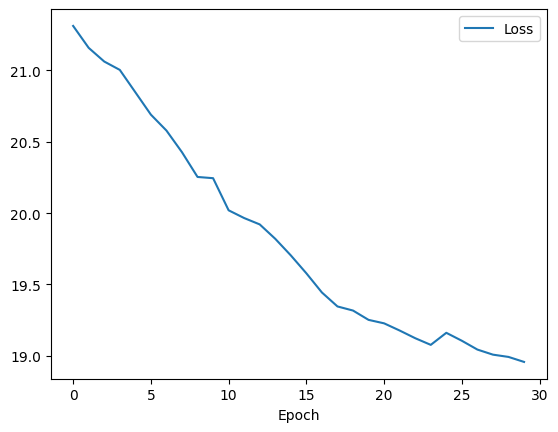

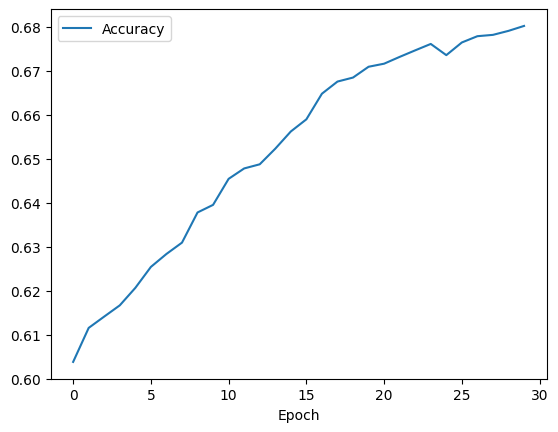

In [ ]:
#@title Sentence Classifier with GNN Implementation 1
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataListLoader
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class SentenceClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
      super(SentenceClassifier, self).__init__()
      self.conv1 = GATConv(input_size, hidden_size)
      self.output = nn.Linear(hidden_size, num_classes)
      self.softmax = nn.Softmax()

  def forward(self, x, edge_index):
      x = self.conv1(x=x, edge_index=edge_index)
      x = nn.functional.relu(x)
      x = self.output(x)
      x = self.softmax(x)
      return x

# Load your custom PyTorch Geometric dataset
dataset = MyGraphDataset("/content/drive/MyDrive/dataset/BBC_NEWS/graphs")

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Define the train and test loaders
train_loader = DataListLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataListLoader(test_dataset, batch_size=32, shuffle=False)

# Instantiate the model and optimizer
model = SentenceClassifier(input_size=768, hidden_size=768, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists for tracking loss and accuracy
loss_list = []
acc_list = []

# Train the model
total = 32953
i = 0
model.train()
for epoch in range(30):
  total_loss = 0
  correct = 0
  # total = 0
  preds_list, labels_list = [], []
  # Train for each batch
  for train_data in train_loader:
    batch_size = len(train_data)
    for d in train_data:
      x, edge_index, train_labels = [], [], []
      x.append(d.x)
      edge_index.append(d.edge_index)
      train_labels.append(d.y)
      x = torch.cat(x, dim=0)
      edge_index = torch.cat(edge_index, dim=1)
      train_labels = torch.cat(train_labels, dim=0).long()
      # Zero gradients
      optimizer.zero_grad()
      # Get outputs
      outputs = model(x=x, edge_index=edge_index)
      # Compute the loss
      loss = nn.functional.cross_entropy(outputs, train_labels)
      i +=1
      # Compute gradients
      loss.backward()
      # Update parameters
      optimizer.step()
      # Update loss and accuracy
      total_loss += loss.item() * batch_size
      preds = outputs.argmax(dim=1)
      preds_list.append(preds.cpu())
      labels_list.append(train_labels.cpu())
      correct += preds.eq(train_labels).sum().item()
  # Print epoch statistics
  avg_loss = total_loss / len(train_loader.dataset)
  print(total)
  print(correct)
  acc = correct / total
  preds_all = torch.cat(preds_list)
  labels_all = torch.cat(labels_list)
  fpr, tpr, thresholds = metrics.roc_curve(labels_all, preds_all)
  roc_auc = metrics.auc(fpr, tpr)
  print(f"AUC: {roc_auc:.4f}")
  tn, fp, fn, tp = confusion_matrix(labels_all, preds_all).ravel()

  # Print the results
  print(f"True Positives: {tp}")
  print(f"True Negatives: {tn}")
  print(f"False Positives: {fp}")
  print(f"False Negatives: {fn}")

  # Calaculate precision, recall and F1-score metrices
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * precision * recall / (precision + recall)
  print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}, Accuracy: {correct/total:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

  # Add loss and accuracy to lists for plotting
  loss_list.append(avg_loss)
  acc_list.append(acc)
# Save the model
torch.save(model.state_dict(), "/content/drive/MyDrive/dataset/BBC_NEWS/gnn_model.pth")
# Plot the loss and accuracy
loss_plot = plt.plot(loss_list, label='Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

acc_plot = plt.plot(acc_list, label='Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#@title Model predictions Implementation 1
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataListLoader
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

model = SentenceClassifier(input_size=768, hidden_size=768, num_classes=2)

model.load_state_dict(torch.load("/content/drive/MyDrive/dataset/BBC_NEWS/gnn_model.pth"))
dataset = MyGraphDataset("/content/drive/MyDrive/dataset/BBC_NEWS/graphs")

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Define the train and test loaders
train_loader = DataListLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataListLoader(test_dataset, batch_size=32, shuffle=False)

model.eval() # set the model to evaluation mode
preds_list, labels_list = [], []
with torch.no_grad():
  for test_data in test_loader:
    batch_size = len(test_data)
    for d in test_data:
      x, edge_index, test_labels = [], [], []
      x.append(d.x)
      edge_index.append(d.edge_index)
      test_labels.append(d.y)
      x = torch.cat(x, dim=0)
      edge_index = torch.cat(edge_index, dim=1)
      test_labels = torch.cat(test_labels, dim=0).long()
      outputs = model(x, edge_index)
      preds = outputs.argmax(dim=1)
      preds_list.append(preds.cpu())
      labels_list.append(test_labels.cpu())

# Combine predictions and labels for the entire test dataset
preds_all = torch.cat(preds_list)
labels_all = torch.cat(labels_list)

# Calculate and print accuracy, AUC, and confusion matrix
acc = metrics.accuracy_score(labels_all, preds_all)
fpr, tpr, thresholds = metrics.roc_curve(labels_all, preds_all)
roc_auc = metrics.auc(fpr, tpr)
tn, fp, fn, tp = confusion_matrix(labels_all, preds_all).ravel()
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {roc_auc:.4f}")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Accuracy: 0.6086
AUC: 0.5600
True Positives: 930
True Negatives: 4213
False Positives: 705
False Negatives: 2602


In [ ]:
#@title Calculating ROUGE Metrics for the Predicted Summaries
from sklearn.model_selection import train_test_split
from rouge import Rouge
dataset = MyGraphDataset("/content/drive/MyDrive/dataset/BBC_NEWS/graphs")
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Composing the predicted summaries
index = 0
pred_summaries = []
for i in range(len(test_dataset)):
  temp = ""
  for sentence in test_dataset[i].sen:
    if preds_all[index] == 1:
      temp =  temp + sentence
      index += 1
      continue
    index += 1
  pred_summaries.append(temp)

# Calculate Rouge scores
rouge_scores =[]
rouge = Rouge()
for i in range(len(pred_summaries)):
  pred_summaries[i] = pred_summaries[i].strip()
  if pred_summaries[i] == "":
    rouge_scores.append({'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}})
    continue
  rouge_scores.append(rouge.get_scores(pred_summaries[i].lower(), test_dataset[i].golden_summarie.lower(), avg=True))

rouge_1_r = 0
rouge_1_p = 0
rouge_1_f = 0
rouge_2_r = 0
rouge_2_p = 0
rouge_2_f = 0
rouge_l_r = 0
rouge_l_p = 0
rouge_l_f = 0

for scores in rouge_scores:
  rouge_1_r += scores['rouge-1']['r']
  rouge_1_p += scores['rouge-1']['p']
  rouge_1_f += scores['rouge-1']['f']
  rouge_2_r += scores['rouge-2']['r']
  rouge_2_p += scores['rouge-2']['p']
  rouge_2_f += scores['rouge-2']['f']
  rouge_l_r += scores['rouge-l']['r']
  rouge_l_p += scores['rouge-l']['p']
  rouge_l_f += scores['rouge-l']['f']

rouge_1_r /= len(rouge_scores)
rouge_1_p /= len(rouge_scores)
rouge_1_f /= len(rouge_scores)
rouge_2_r /= len(rouge_scores)
rouge_2_p /= len(rouge_scores)
rouge_2_f /= len(rouge_scores)
rouge_l_r /= len(rouge_scores)
rouge_l_p /= len(rouge_scores)
rouge_l_f /= len(rouge_scores)

print("ROUGE-1: Recall: " + str(rouge_1_r) + " Percision: " + str(rouge_1_p) + " F1 Score: " + str(rouge_1_f))
print("ROUGE-2: Recall: " + str(rouge_2_r) + " Percision: " + str(rouge_2_p) + " F1 Score: " + str(rouge_2_f))
print("ROUGE-l: Recall: " + str(rouge_l_r) + " Percision: " + str(rouge_l_p) + " F1 Score: " + str(rouge_l_f))

ROUGE-1: Recall: 0.38444923069751874 Percision: 0.6284480733916559 F1 Score: 0.426118205403552
ROUGE-2: Recall: 0.31035628710487373 Percision: 0.546514117313621 F1 Score: 0.34043573061679544
ROUGE-l: Recall: 0.3797099107934812 Percision: 0.6196075769534996 F1 Score: 0.42038664262594105
